In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

from PIL import Image

In [2]:
# get all file names
path = 'w_numbers/2'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)
n

10000

In [3]:
y = np.zeros(shape=(n,2),dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    y[i,0] = re.search('^([0-9]*)_([0-9]*)',files[i])[1]
    y[i,1] = re.search('^([0-9]*)_([0-9]*)',files[i])[2]
    # get the pixels, remove the alpha if needed and convert to 0-255
    X[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

In [4]:
# transform y to label encoded
temp = y.copy()
y = np.zeros(shape=(n,24),dtype=int)
for i in range(n):
    # hours, 0 to 11 for 1 to 12
    h = temp[i,0] -1
    # minutes 12 to 23 for 0 to 55
    m = temp[i,1]//5 + 12
    y[i,h] = 1
    y[i,m] = 1

5_40_clock_9915.png
5 40
[0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0]


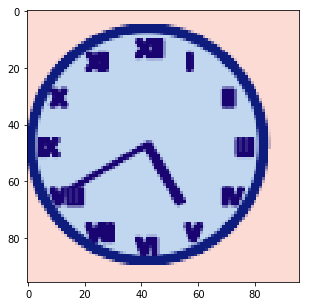

In [5]:
i = np.random.randint(0,n)
print(files[i])
print(temp[i,0],temp[i,1])
print(y[i,:12])
print(y[i,12:])
plt.figure(figsize=(5,5))
plt.imshow(X[i])
plt.show()

In [6]:
p = 0.9
c = int(len(X) * p)

X_train = X[:c]
y_train = y[:c]

X_test = X[c:]
y_test = y[c:]

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Flatten, MaxPooling2D, Dropout

Using TensorFlow backend.


In [8]:
input_layer = Input(shape=shape)
conv1 = Convolution2D(18, kernel_size=3,activation='relu')(input_layer)
conv2 = Convolution2D(36, kernel_size=3,activation='relu')(conv1)
pool = MaxPooling2D()(conv2)
hidden = Dense(128,activation='relu')(Flatten()(pool))
drop = Dropout(rate=0.5)(hidden)
output1 = Dense(12, activation='softmax')(drop)
output2 = Dense(12, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=[output1, output2])
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'], loss_weights=[1., 1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.fit(X_train, [y_train[:,:12],y_train[:,12:]],
          epochs=10,
          batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
9000/9000 [==============================] - 284s 32ms/step - loss: 4.8976 - dense_2_loss: 2.4898 - dense_3_loss: 2.4078 - dense_2_acc: 0.1072 - dense_3_acc: 0.1472
Epoch 2/10
9000/9000 [==============================] - 288s 32ms/step - loss: 4.0966 - dense_2_loss: 2.4569 - dense_3_loss: 1.6397 - dense_2_acc: 0.1400 - dense_3_acc: 0.4119
Epoch 3/10
9000/9000 [==============================] - 297s 33ms/step - loss: 3.3019 - dense_2_loss: 2.4694 - dense_3_loss: 0.8325 - dense_2_acc: 0.1170 - dense_3_acc: 0.7127
Epoch 4/10
9000/9000 [==============================] - 288s 32ms/step - loss: 2.9385 - dense_2_loss: 2.4436 - dense_3_loss: 0.4949 - dense_2_acc: 0.1306 - dense_3_acc: 0.8256
Epoch 5/10
9000/9000 [==============================] - 282s 31ms/step - loss: 2.7522 - dense_2_loss: 2.3762 - dense_3_loss: 0.3761 - dense_2_acc: 0.1559 - dense_3_acc: 0.8676
Epoch 6/10
9000/9000 [==============================] - 278s 31ms/step -

In [10]:
model.evaluate(X_test, [y_test[:,:12],y_test[:,12:]], batch_size=10)

1000/1000 [==============================] - 6s 6ms/step


[1.2834749293327332,
 1.1327201175689696,
 0.15075480891013285,
 0.6250000078976155,
 0.9589999938011169]

In [13]:
model.save('220319_ms.h5')

In [14]:
model.save_weights('220319_msw.h5')

In [11]:
path = 'google_images'
files = listdir(path)
len(files)

41

(96, 96, 3)


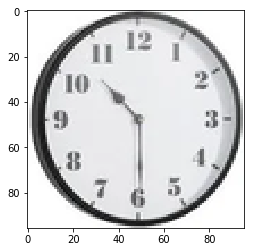

6:55
[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)]
(96, 96, 3)


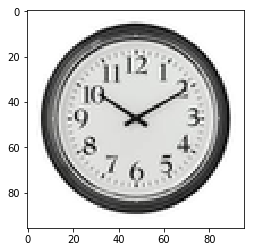

5:10
[array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.6068148e-09, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


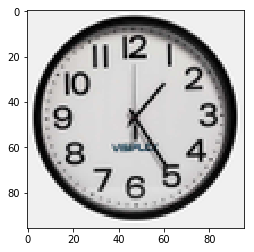

5:25
[array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


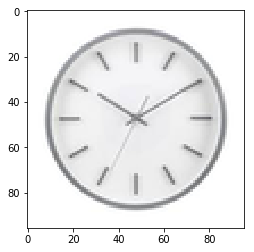

10:10
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


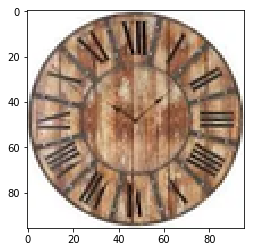

12:0
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32), array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 90, 3)
5
(96, 96, 3)


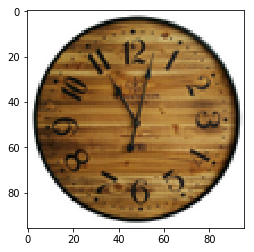

11:50
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)]
(96, 96, 3)


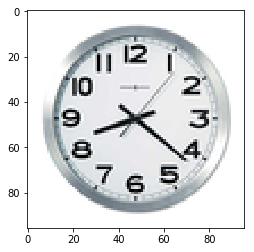

5:20
[array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 4)
8
(96, 95, 3)
9
(96, 96)
10
(96, 78, 3)
11
(96, 96, 3)


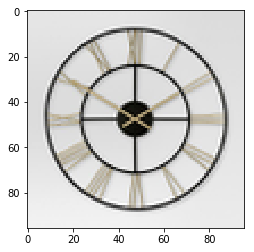

2:15
[array([[0.0000000e+00, 1.0000000e+00, 1.3199206e-32, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32), array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


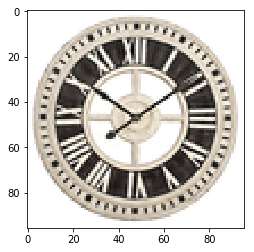

10:40
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


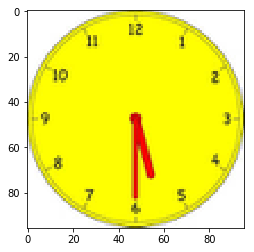

6:30
[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


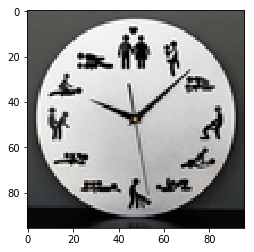

5:10
[array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(64, 96, 3)
16
(96, 96, 3)


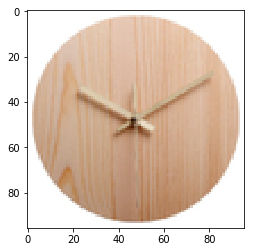

12:10
[array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 4.232885e-20, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]],
      dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(72, 96, 3)
18
(96, 96, 3)


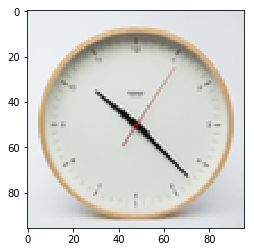

10:25
[array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        8.764979e-24, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00]],
      dtype=float32), array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


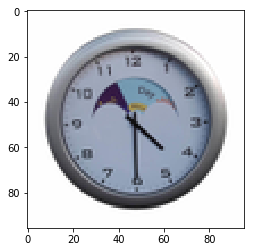

6:25
[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 82, 3)
21
(64, 96, 3)
22
(74, 96, 3)
23
(96, 96, 3)


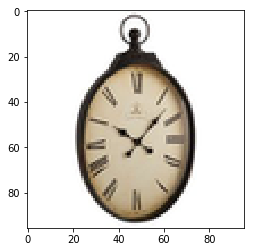

11:35
[array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.0110737e-34,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 9.4206457e-32]],
      dtype=float32), array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        4.8877655e-29, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)]
(96, 96)
25
(95, 96)
26
(96, 96, 3)


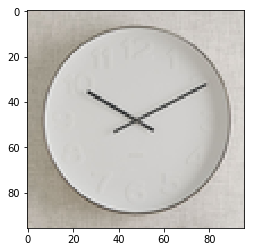

10:10
[array([[0.0000000e+00, 0.0000000e+00, 1.6453916e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 9.9999988e-01, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


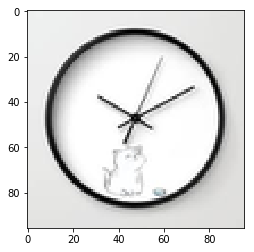

3:10
[array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


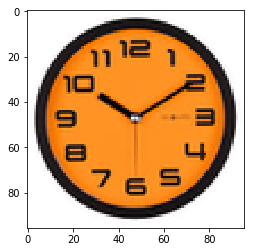

3:10
[array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        8.1617725e-21, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 4)
30
(96, 96, 3)


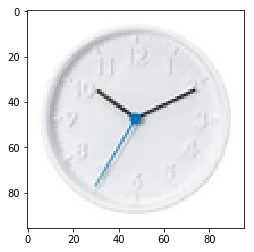

3:10
[array([[0.0000000e+00, 5.3313816e-08, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(72, 96, 3)
32
(96, 78, 3)
33
(96, 96, 3)


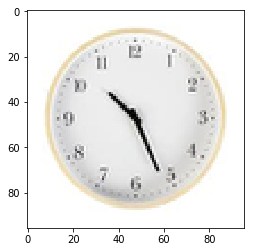

5:25
[array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


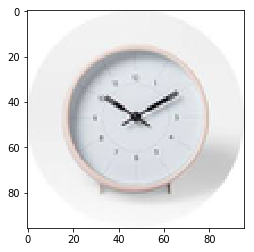

5:10
[array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


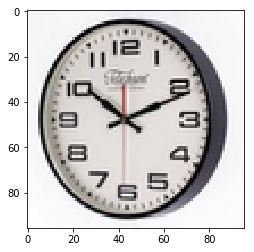

3:10
[array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(68, 96, 3)
37
(96, 96, 3)


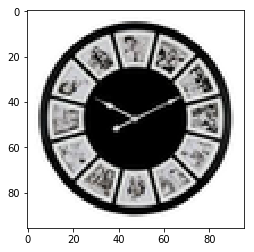

8:10
[array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
(96, 96, 3)


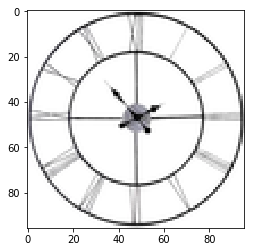

6:30
[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)]
(50, 96, 3)
40


In [12]:
for i in range(41):
    img = Image.open(path+'/'+files[i])
    img.thumbnail((96, 96), Image.ANTIALIAS) # resizes image in-place
    img = np.asarray(img)
    print(img.shape)
    if (img.shape[:3] == (96,96,3)):   
        imgplot = plt.imshow(img)
        plt.show()
        pred = model.predict(img.reshape(1,96,96,3))
        h = np.argmax(pred[0])+1
        m = np.argmax(pred[1])*5
        print(str(h)+":"+str(m))
        print(pred)
    else:
        print(i)